# About BData

In this notebook, I introduce *BData*, which is the neural signal data format used in the Kamitani Lab.  
I briefly explain its structure, how to use it, and how to construct a simple BData object.

BData is a data format defined in **bdpy** (brain decoder toolbox for python).  
In the Kamitani Lab, it is mainly used as the default format for pre–machine‑learning fMRI data \*1.

Because BData is accessible through various bdpy functions, it is easy to:
- extract samples corresponding to specific stimuli,
- extract data from a specified ROI,
- and perform other common operations.

\*1 In the past, it was also sometimes used to store DNN features.

## Structure of BData

### Signal Data

A BData object mainly consists of two parts:

- `dataset`, which stores the neural **signal data**
- `metadata`, which stores information such as ROI definitions and voxel coordinates

`dataset` is a 2-D matrix of shape:

> **samples × voxels (+ additional information)**

Each **row** of `dataset` corresponds to one sample.  
In Kamitani Lab BData, this is typically the average of 4 TRs of fMRI signal.

Original fMRI data (NIfTI) are 3-D volume data, but in BData one volume is **flattened** to 1-D form and stacked as 2-D matrix.

First, let us load BData and inspect the `dataset`.\
You can see that it is a 2D numpy ndarray including `float64` values.

In [7]:
# Please run this cell on Google Colab
!pip install bdpy
!git clone https://github.com/micchu/BData_introduction_2025.git
%cd BData_introduction_2025
%ls


Cloning into 'BData_introduction_2025'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 3), reused 18 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 18.36 MiB | 27.05 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/BData_introduction_2025/BData_introduction_2025
BData_introduction_en.ipynb  BData_introduction_jp.ipynb  data/  README.md


In [8]:
import bdpy

print("Loading BData...")
bdata = bdpy.BData("data/fmri/test.h5")
print("Done.")
print()

print("bdata.dataset type:      {}".format(type(bdata.dataset)))
print("bdata.dataset shape: {}".format(bdata.dataset.shape)) # bdata.dataSet is also OK.
print("bdata.dataset dtype:     {}".format(bdata.dataset.dtype))
print("bdata.dataset values:", bdata.dataset[:8, :8])

Loading BData...
Done.

bdata.dataset type:      <class 'numpy.ndarray'>
bdata.dataset shape: (150, 16523)
bdata.dataset dtype:     float64
bdata.dataset values: [[ 2.64518704 -0.44347996 -3.37798983 -0.57282697 -0.92741706 -3.49550998
  -3.14150622 -0.48752904]
 [ 3.76319237 -0.60811014 -1.18836102 -0.57758604  1.36868343  1.05252092
  -1.71123963  0.88166515]
 [-2.80220216 -2.3958488   6.21237825  9.37242085 -0.16697923 -1.24376157
  -2.8192875   2.19723338]
 [ 3.53650401  1.76475498 -6.01719133  2.87098774  0.81761793 -3.37047287
   1.07991111 -1.00136841]
 [ 0.03544101 -0.54389622  3.96620149  3.89384244  2.27698797  1.14807738
  -4.21227142 -4.90578278]
 [-2.33653962  0.33844415 -2.72500789 -1.50111756  2.52267163  0.01018683
   4.41346553  3.75870502]
 [-1.13686514  7.26429493 -1.72412771  1.91131915  2.511056   -1.81276201
   0.18399745  2.70960368]
 [ 0.56389299 -0.88815725  4.1970826   0.22870231 -3.27654934 -1.65964392
   0.05592444  2.31757844]]


On the other hand, `metadata` mainly consists of three components:

- `value`
- `key`
- `description`

`bdata.metadata.value` is a matrix whose number of **columns** is the same as that of `bdata.dataset`.  
This is because each column of `bdata.metadata.value` corresponds **one‑to‑one** to a column of `bdata.dataset`.

`bdata.metadata.value` is a numeric matrix of type `float64` as like `bdata.dataset`.


In [9]:
print("bdata.metadata.value")
print()
print("bdata.dataset type:         {}".format(type(bdata.dataset)))
print("bdata metadata.value shape: {}".format(bdata.metadata.value.shape))
print("bdata metadata.value dtype: {}".format(bdata.metadata.value.dtype))
print("bdata.dataset values:", bdata.metadata.value[:8, :8])


bdata.metadata.value

bdata.dataset type:         <class 'numpy.ndarray'>
bdata metadata.value shape: (59, 16523)
bdata metadata.value dtype: float64
bdata.dataset values: [[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]


The relationship between `bdata.dataset` and `bdata.metadata.value` can be illustrated as follows.

When we refer to the `ROI_V1` row of `metadata.value`, the columns in that row whose value is **1** indicate the columns to be extracted from `dataset` as **ROI_V1** signal data.  

Inversely, the columns with values **0** or **NaN** are **not** selected when extracting an ROI.



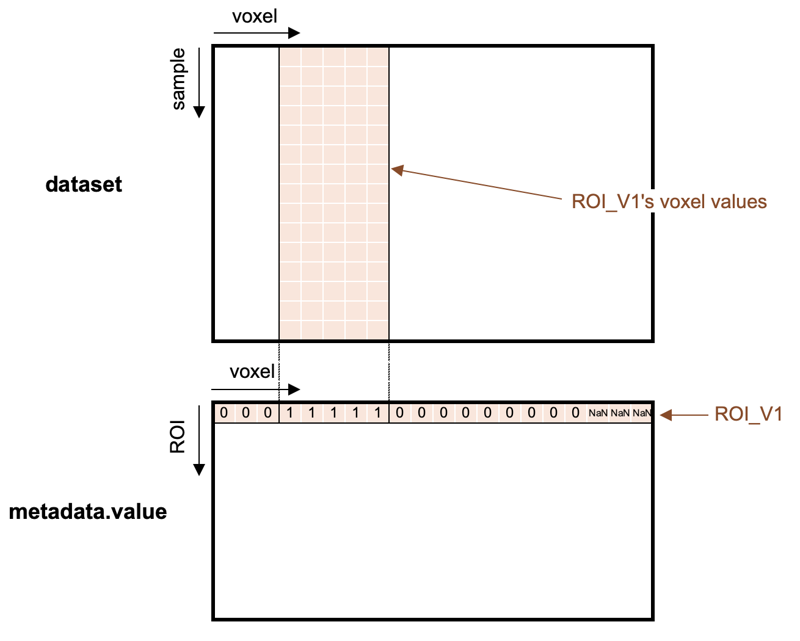

In [16]:
from PIL import Image

img = Image.open("data/img/BData_structure.png")
img.thumbnail((800, 800))
display(img)


Each row of `bdata.metadata.value` is associated with entries in two lists:

- `bdata.metadata.key`
- `bdata.metadata.description`

Please run the following code.\
`metadata.key` stores which ROI (or which type of information) each row of `metadata.value` corresponds to. Therefore, its list length is the same as the number of rows of `metadata.value`.\
`metadata.description` stores a textual description of these ROI or information. For example, the file path of the ROI mask or which ROIs were concatenated.


In [18]:
print("bdata metadata.key length:     {}".format(len(bdata.metadata.key)))
print("bdata metadata.key datatype:   {}".format(type(bdata.metadata.key)))
print("bdata metadata.key:", bdata.metadata.key[:8])
print()

print("bdata metadata.description length:     {}".format(len(bdata.metadata.description)))
print("bdata metadata.description datatype:   {}".format(type(bdata.metadata.description)))
print("bdata metadata.description:", bdata.metadata.description[:8])
print()



bdata metadata.key length:     59
bdata metadata.key datatype:   <class 'list'>
bdata metadata.key: ['VoxelData', 'Session', 'Run', 'Block', 'Label', 'MotionParameter', 'MotionParameter_trans_x', 'MotionParameter_trans_y']

bdata metadata.description length:     59
bdata metadata.description datatype:   <class 'list'>
bdata metadata.description: ['1 = VoxelData', '1 = Session', '1 = Run', '1 = Block', '1 = Label', '1 = MotionParameter', 'Motion parameter: x translation', 'Motion parameter: y translation']



For example, suppose we want to obtain the signal data for `"ROI_V1"`.

We first search `"ROI_V1"` from the `metadata.key` and get the index.\
Next, we obtain the row in `metadata.value` corresponding to the found index.\
Then we look at that row and find the columns whose values are **1** and extract those columns from `bdata.dataset`.

The resulting matrix is the signal data for **ROI_V1**.


In [17]:
import numpy as np

# Get "ROI_V1" index from key list.
key_index = bdata.metadata.key.index("ROI_V1")
print("ROI_V1 index in metadata.key:", key_index)

# Get "ROI_V1" selector
vox_selector = bdata.metadata.value[key_index]
print("ROI_V1 selector:", vox_selector)
print("ROI_V1 voxel column index:", np.where(vox_selector == 1)[0])

# Extract ROI_V1 signal values
vox_selector = vox_selector.astype(bool)
vox = bdata.dataset[:, vox_selector]
print("ROI_V1 datashape:", vox.shape)


ROI_V1 index in metadata.key: 49
ROI_V1 selector: [0. 0. 0. ... 0. 0. 0.]
ROI_V1 voxel column index: [   19    20    21 ... 14498 14499 14500]
ROI_V1 datashape: (150, 3205)


In practice, we normally use `get()` rather than manipulating `dataset` and `metadata` directly.


In [19]:
vox = bdata.get("ROI_V1")
print("ROI_V1 datashape:", vox.shape)


ROI_V1 datashape: (150, 3205)


We are also have helper functions to access `bdata.metadata` itself. Please run the following code.

- `get_metadata()`: retrieves a row from `metadata.value` by key.
- `select()`: a more powerful function of `get()` that allows simultaneous extraction of both `dataset` and `metadata` entries by using `return_index` option.

By using `get_metadata()` and `select()`, we can obtain voxel selectors and other useful vectors directly from a BData object.

Note that `get_metadata()` returns the values stored in `metadata.value` as they are, so the returned arrays may contain `np.nan`.  
Sometimes, this occurs unexpected behaviour.


In [24]:
print("Use get_metadata()")
vox_selector = bdata.get_metadata("ROI_V1")
print("  ROI_V1 selector:    {}".format(vox_selector))
print("  ROI_V1 voxel size:  {}".format(np.sum(vox_selector)))
print()

print("Use select() with `return_index` option")
vox, vox_selector = bdata.select("ROI_V1", return_index=True)
print("  ROI_V1 selector     {}".format(vox_selector))
print("  ROI_V1 voxel size:  {}".format(np.sum(vox_selector)))


Use get_metadata()
  ROI_V1 selector:    [0. 0. 0. ... 0. 0. 0.]
  ROI_V1 voxel size:  3205.0

Use select() with `return_index` option
  ROI_V1 selector     [False False False ... False False False]
  ROI_V1 voxel size:  3205


To summarise:

- **Use `BData.get()` to access `BData.dataset`.**
- **Use `BData.get_metadata()` to access `BData.metadata.value`.**
- **Use `BData.select()` to access `dataset` and `metadata.value` together.**

In the most common use case of `get_metadata()`, we can obtain voxel coordinate.  
If using the Lab standard BData creation function (`bdpy.mri.create_bdata_fmriprep()`) \*2, `metadata` contains rows such as

- `voxel_x`, `voxel_y`, `voxel_z`
- `voxel_i`, `voxel_j`, `voxel_k`

Please run the following code.\
`voxel_x`, `voxel_y`, `voxel_z` represent the **MNI coordinates** of each voxel.  
`voxel_i`, `voxel_j`, `voxel_k` represent the **voxel coordinates**, which is the indices of each voxel in the 3-D volume, when the volume is viewed as a 3-D matrix with one corner as the origin.

We can reconstruct the original 3-D volume data from the flattened signals in BData by using these coordinates.  
(About this procedure, please refer to the other material [BData to 3D to flattend](https://www.notion.so/BData-to-3D-to-flattend-1ad464d9d08d4b9d82add29c7e0d9522).)

\*2 `make_bdata.py` script uses this function to create raw BData from NIfTI files.


In [23]:
voxel_x, voxel_y, voxel_z = bdata.get_metadata("voxel_x"), bdata.get_metadata("voxel_y"), bdata.get_metadata("voxel_z")
print("voxel_x:", voxel_x)
print("voxel_y:", voxel_y)
print("voxel_z:", voxel_z)
print()

voxel_i, voxel_j, voxel_k = bdata.get_metadata("voxel_i"), bdata.get_metadata("voxel_j"), bdata.get_metadata("voxel_k")
print("voxel_i:", voxel_i)
print("voxel_j:", voxel_j)
print("voxel_k:", voxel_k)



voxel_x: [-23.5 -21.5 -19.5 ...   nan   nan   nan]
voxel_y: [-96.03255463 -96.03255463 -96.03255463 ...          nan          nan
          nan]
voxel_z: [-25.59396362 -25.59396362 -25.59396362 ...          nan          nan
          nan]

voxel_i: [26. 27. 28. ... nan nan nan]
voxel_j: [ 9.  9.  9. ... nan nan nan]
voxel_k: [19. 19. 19. ... nan nan nan]


In addition, by combining these coordinate vectors with the ROI selector above, it is possible to extract coordinate for a specific ROI.

Note that when you do this you are **selecting along the column dimension**, just as when you extract voxel data from `dataset`.


In [ ]:
voxel_x, voxel_y, voxel_z = bdata.get_metadata("voxel_x"), bdata.get_metadata("voxel_y"), bdata.get_metadata("voxel_z")
vox_selector = bdata.get_metadata("ROI_V1")
print("ROI_V1's voxel_x coordinate:", voxel_x[vox_selector.astype(bool)])
print("ROI_V1's voxel_y coordinate:", voxel_y[vox_selector.astype(bool)])
print("ROI_V1's voxel_z coordinate:", voxel_z[vox_selector.astype(bool)])


### Sample information

Next we describe how to access information other than voxels.

`bdata.dataset` mainly contains voxel signals. But it can also store per‑sample information such as

- stimulus indices,
- run numbers,
- session numbers, and so on.

These are also obtained from `bdata.dataset` via `bdata.metadata`.  
For example, when you access the `"Run"` row in `bdata.metadata.value`, the corresponding column vector is extracted from `bdata.dataset`.  
This vector contains the run index for each sample.


In [ ]:
from PIL import Image

img = Image.open("data/img/BData_structure2.png")
img.thumbnail((800, 800))
img


If we want to select samples by using these retrieved run indices, please remember to **flatten** the column vector first.

Just asfter extraction, the run indices are stored as a 2-D column array, because they were cut out from `bdata.dataset`, which is a 2-D matrix.
After flattening this array, it turns it into a 1-D array of length *n_samples*.


In [ ]:
# Get run metadata
run_selector = bdata.get_metadata("Run")
print("run_selector:", run_selector)
print("run index:",    np.where(run_selector == 1)[0])
print()

# Get run index list
runs = bdata.get("Run")
print("runs.shape:", runs.shape)
print("runs:", runs)
print()

# Error !!
# vox[runs == 1, :]

# Success
print("Run=1 voxel datashape:", vox[runs.flatten() == 1, :].shape)


To summarise:

- Information that corresponds **one‑to‑one to rows** (samples) is stored in **`bdata.dataset`**.
- Information that corresponds **to columns** (voxel range or other infomation range) is stored in **`bdata.metadata`**.


### Label information

Among the sample information, the **label** is treated slightly specially.  
Many sample information it can be obtained by `get()`. But if we use `BData.get_label()`, we can obtain not numeric values but a list of **string stimulus names**.


In [ ]:
print("Get it as a numeric index array")
stimulus_index_array = bdata.get("stimulus_name")
print(stimulus_index_array)


In [ ]:
print("Get it as a list of stimulsu name")
stimulus_name_list = bdata.get_label("stimulus_name")
print(stimulus_name_list)

These text information are stored in a dictionary object in the BData called **vmap**.  vmap is stored in BData separately from `dataset` and `metadata`.

If we call `get_vmap()` and pass the metadata key of the column having a vmap (for example `"stimulus_name"`), we can inspect the dictionary that maps numeric indices to stimulus names.

Using this mapping, `BData.get_label()` converts the numeric indices into human‑readable stimulus names.


In [ ]:
from pprint import pprint

pprint(bdata.get_vmap("stimulus_name"))

### Listing information in a BData object

In order to understand the structure of BData, we have directly accessed `dataset` and `metadata` so far.

In practice, actually, we can usually grasp the overall profiles of BData just by checking two:

- `BData.dataset.shape`
- `BData.show_metadata()`

`BData.dataset.shape` tells you the number of samples and the number of columns.  
`BData.show_metadata()` lists the keys stored in `metadata` and their brief descriptions.


In [ ]:
# Confirm BData size

bdata.dataset.shape

In [ ]:
# Confirm ROIs in BData

bdata.show_metadata()

### Supplement: Reserved keys in BData

As mentioned above, BData (in particular, fMRI BData created with the lab's  `make_bdata.py` script) uses several **reserved key names**.
If you build a BData object completely from scratch, these may not exist, but for standard fMRI BData you should be aware of them.

1. **Reserved keys for voxel coordinates**

   - `voxel_x`, `voxel_y`, `voxel_z`  
     - MNI coordinates of each voxel.
   - `voxel_i`, `voxel_j`, `voxel_k`  
     - Voxel coordinates (matrix indices) of each voxel in the 3‑D volume.

2. **Reserved keys for per‑sample information**

   Typical examples include:

   - `Block`, `Run`, `Session`, `Trial`, etc.  
     - Basic task / acquisition information for each sample.
   - `MotionParameter_trans_x`, `MotionParameter_trans_y`, `MotionParameter_trans_z`,  
     `MotionParameter_rot_x`, `MotionParameter_rot_y`, `MotionParameter_rot_z`  
     - Basic head‑motion parameters.
   - `GlobalSignal`, `WhiteMatterSignal`, `CSFSignal`, `DVARS`, `STDVARS`,  
     `FramewiseDisplacement`, `aCompCor`, `tCompCor`, `Cosine`  
     - Additional nuisance regressors derived from the data.
   - `trial_type`, `stimulus_name`, `response_time`  
     - Information imported from task‑event files.  
       (If you change the column names in the event file, these keys will also change.)

3. **Reserved keys that indicate signal ranges**

   - `VoxelData`  
     - Indicates the column range in `BData.dataset` that corresponds to voxel signals  
       (for surface data this may instead be `VertexData`).

When you construct your own BData objects, please avoid using these reserved names for unrelated purposes.


## How to construct BData

Here we explain a simple way to construct a BData object.  

Note that, when converting existing fMRI data (NIfTI) into BData, the actual procedure is more complex and usually handled by scripts such as `make_bdata.py`. Here, we deliberately ignore the full NIfTI pipeline and instead build BData from simple **test data** in order to learn the basic operations on BData objects.

### Step1: Create an empty BData

First, let us create an empty BData object.


In [ ]:
bdata = bdpy.BData()
print(bdata.dataset.shape)


### Step2: Add VoxelData

Next, we create a `10 × 20` random‑value matrix.  
This dummy data represents **10 samples × 20 voxels**.

Then, add this matrix to the empty BData object as **`VoxelData`**.


In [ ]:
import numpy as np

random_vox = np.random.random([10, 20])
bdata.add(random_vox, name="VoxelData")

# Get VoxelData
vox = bdata.get("VoxelData")
print("VoxelData shape:", vox.shape)


### Step2: Add sample information such as Run

Next, let us add sample‑level information. As an example we add a **Run index** for each sample.

After running the code you should see that:

- the number of columns in `dataset` has increased by one, and  
- `"Run"` has been added to `metadata.key`.

In other words, one extra column has been appended to `BData.dataset`,  
and a corresponding row with key `"Run"` has been appended to `metadata`.


In [ ]:
print("Before add run index")
print("  BData dataset shape: {}".format(bdata.dataset.shape))
print("  BData metadata.key:  {}".format(bdata.metadata.key))

run_index = np.array([1,1,1,1,1,2,2,2,2,2]) # The first 5 samples are from the 1st run. The remaining samples are from the 2nd run.
run_index = run_index.reshape(-1, 1) # Reshape to column vector (sample x 1)
bdata.add(run_index, name="Run")

print("After add run index")
print("  BData dataset shape: {}".format(bdata.dataset.shape))
print("  BData metadata.key:  {}".format(bdata.metadata.key))

Using the information stored in the newly added column, we can select only the samples that satisfy a particular condition  (e.g. samples from a specific run).


In [ ]:
runs = bdata.get("Run")
print("Run:", runs)
vox = bdata.get("VoxelData")[runs.flatten() == 1]
print("1st Run's voxel shape:", vox.shape)

### Step3: Add labels

Next, we add stimulus information as labels. We also add the corresponding **vmap** so that calling `get_label()` returns the human-readable stimulus names.


In [ ]:
sample_index = np.array([1,2,3,4,5,6,7,8,9,10])
vmap = {
    1: "dog",
    2: "cat",
    3: "chicken",
    4: "flamingo",
    5: "snake",
    6: "lizard",
    7: "flog",
    8: "axolotl",
    9: "goldenfish",
    10: "shark",
}
bdata.add(sample_index, name="stimulus_name")
bdata.add_vmap(key="stimulus_name", vmap=vmap)

print(bdata.get("stimulus_name"))
print(bdata.get_label("stimulus_name"))


We can also additional vmap. Here, we add **category names**.  
(e.g. “mammal”, “bird”, etc.) for each stimulus.


In [ ]:
category_index = np.array([1,1,2,2,3,3,4,4,5,5])
vmap = {
    1: "mammal", # 哺乳類
    2: "bird", # 鳥類
    3: "reptile", # 爬虫類
    4: "amphibian", # 両生類
    5: "fish", # 魚類
}
bdata.add(category_index, name="category_name")
bdata.add_vmap(key="category_name", vmap=vmap)

print(bdata.get("category_name"))
print(bdata.get_label("category_name"))


For example, to extract only the samples belonging to the “mammal” category, we can operate as follows.


In [ ]:
vox = bdata.get("VoxelData")
categories = np.array(bdata.get_label("category_name")) # Convert to array type to get boolean array by comparison
mammal_vox = vox[categories == "mammal", :]
print(mammal_vox.shape)


### Step4: Add metadata (ROI)

Finally, we add a new ROI under `"VoxelData"`.  
Here we assume that, out of the 20 voxels, the first 8 voxels belong to `"ROI_V1"`.

We create a boolean array of the same length as the number of voxels of `"VoxelData"`, and set `True` only for the columns that belong to `"ROI_V1"`.  
We then pass this array to `add_metadata()` with the key `"ROI_V1"` and with a `where` argument that specifies the `"VoxelData"` column range.

As a result, a new row corresponding to `"ROI_V1"` is added to `metadata.value`, and we can use it to extract voxel columns for this ROI.


In [ ]:
# Get voxel size from the number of columns in "VoxelData"
voxel_size = bdata.get("VoxelData").shape[1]
print("voxel size:            {}".format(voxel_size))

# Create a boolean array specifying the range of "ROI_V1" (Here, assuming the first 8 voxels are "ROI_V1".)
vox_selector = np.zeros(voxel_size).astype(bool)
vox_selector[0:8] = True
print("V1 voxel in VoxelData: {}".format(vox_selector))

# Add ROI information for "ROI_V1" under "VoxelData"
bdata.add_metadata(key="ROI_V1", value=vox_selector, where="VoxelData")

# To confirm, get "ROI_V1".
vox, vox_selector = bdata.select("ROI_V1", return_index=True)
print("ROI_V1 dataset shape:  {}".format(vox.shape))
print()

When we add a new row to `metadata.value` in this way, the entries outside the range specified by `where` are filled with **NaN**.

In our example we had already added the non `"VoxelData"` columns, such ad `"Run"`, `"stimulus_name"`, and `"category_name"` column to `dataset`.  
Therefore, in the `"ROI_V1"` row of `metadata.value`, the last three columns corresponding to these fields become NaN (`nan`).

In general, any part of `metadata.value` that is not explicitly specified when using `add_metadata()` will be filled with NaNs.  
Please keep this in mind.


In [ ]:
vox_selector = bdata.get_metadata("ROI_V1")
print(vox_selector)


In [ ]:
print(bdata.metadata.value)

Note that, when we add ROIs to **real** fMRI BData, the actual procedure is more complicated than this toy example.

In practice we:

1. prepare the necessary ROI mask NIfTI files,
2. use functions such as `bdpy.mri.roi.add_roimask()` to project those masks onto the BData space,  
   selecting the appropriate voxel columns based on the voxel MNI coordinates and other spatial information.

The procedure introduced in this notebook is therefore only a **simplified** version for explanatory purposes.


## Supplement

### Creating BData from NIfTI / BIDS structures

When creating BData from NIfTI data, the main functions involved are defined in `bdpy.mri`:

- `create_bdata_fmriprep()`  
  - Takes the path to a **BIDS directory**, reads multiple NIfTI files under that directory, and returns either a single BData file or a list of BData objects.
- `BrainData()`  
  - Takes the path to a **NIfTI file** and creates an object containing the signal data and coordinate information extracted from that file.

In the Kamitani Lab standard pipeline, `make_bdata.py` internally calls `create_bdata_fmriprep()`.

### Deleting information from BData

At present, bdpy does not provide dedicated functions for deleting columns or keys from a BData object.  
However, as described above, such operations can be performed relatively easily by direct matrix manipulation of `dataset` and `metadata`.

Old BData files are often very large, so when sharing or publishing data it is usually preferable to prepare a **trimmed** version in which unnecessary columns and keys have been removed.


In [ ]:
import numpy as np
import fnmatch


def remove_data(bdata, remover):
    """
    Remove selected ROIs (columns) from a BData object.

    Columns for which ``remover`` is True are removed from both
    ``bdata.dataset`` and ``bdata.metadata.value``. The input object
    is modified in-place and returned.

    Parameters
    ----------
    bdata : BData

    remover : array_like of bool, shape (n_roi,)
        One-dimensional boolean mask specifying which ROIs (columns)
        to remove. Columns with True are removed; columns with False
        are kept. The length must match the number of columns in
        ``bdata.dataset`` and ``bdata.metadata.value``.

    Returns
    -------
    bdata : BData object after column removal.

    Notes
    -----
    This function mutates ``bdata`` in-place. If you need to preserve
    the original object, create a copy beforehand.
    """
    bdata.dataset = bdata.dataset[:, np.logical_not(remover)]
    bdata.metadata.value = bdata.metadata.value[:, np.logical_not(remover)]
    return bdata


def remove_metadata(bdata, keypattern, verbose=True):
    """
    Remove metadata entries that match a key pattern.

    Uses :func:`fnmatch.fnmatchcase` for pattern matching and removes
    metadata rows (key, value, description) whose keys match the given
    pattern. Wildcards are supported, e.g. ``"hcp180_*"``. The input
    object is modified in-place and returned.

    Parameters
    ----------
    bdata : BData

    keypattern : str
        Pattern string used to select metadata keys to remove. Passed
        directly to :func:`fnmatch.fnmatchcase`. For example:
        ``"hcp180_*"``, ``"freesurfer_*"``, or ``"*motion*"``.

    verbose : bool, default True
        If True, prints the names of removed keys to standard output.
        Set to False to disable logging.

    Returns
    -------
    bdata : BData object after metadata removal.

    Notes
    -----
    This function mutates ``bdata`` in-place. If you need to preserve
    the original metadata, create a copy beforehand.
    """
    # Search metadata keys
    survive_keys = np.ones(bdata.metadata.value.shape[0]).astype(bool)
    for i, metakey in enumerate(bdata.metadata.key):
        if fnmatch.fnmatchcase(metakey, keypattern):
            survive_keys[i] = False
            if verbose:
                print("Remove:", metakey)
    # Remove metadata
    key = list(np.array(bdata.metadata.key)[survive_keys])
    value = bdata.metadata.value[survive_keys]
    desc = list(np.array(bdata.metadata.description)[survive_keys])
    # Replace metadata.key, value, description
    bdata.metadata.key = key
    bdata.metadata.value = value
    bdata.metadata.description = desc
    return bdata